# BART finetuning with AdamW optimizer

-> The results are a bit worse than with those obtained with AdamW-paged 8 bit optimizer.

In [2]:
import torch

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_in_use = torch.cuda.memory_allocated(0)
    gpu_memory_free = torch.cuda.memory_reserved(0)
    
    print(f"Total GPU Memory: {gpu_memory / 1e9:.2f} GB")
    print(f"Memory in Use: {gpu_memory_in_use / 1e9:.2f} GB")
    print(f"Free Memory: {gpu_memory_free / 1e9:.2f} GB")
else:
    print("CUDA is not available")

Total GPU Memory: 99.87 GB
Memory in Use: 1.63 GB
Free Memory: 2.05 GB


# Load model and dataset

In [1]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', use_fast=True)
model =  BartForConditionalGeneration.from_pretrained('facebook/bart-large', device_map ={'':torch.cuda.current_device()})

In [3]:
from datasets import load_from_disk

tokenized_datasets = load_from_disk("../data/tokenized_swipe_dataset")

# Training

In [6]:
# per_device_train_batch_size = 6
# num_train_epochs = 3
total_steps = (len(tokenized_datasets['train']) // 6) * 3
print("Total steps: " ,total_steps)
warmup_steps = int(total_steps * 0.05) 
print("Warmup steps: ", warmup_steps)

Total steps:  1923
Warmup steps:  96


In [8]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    output_dir="../models/bart-swipe/results-adamw",
    eval_strategy="epoch", 
    save_strategy = "epoch", 
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5, 
    per_device_train_batch_size=6, # 6 -> 4 2 
    per_device_eval_batch_size=6, # 6 -> 4 2
    num_train_epochs=3, # 3 -> 10 -> 20
    weight_decay=0.01,
    save_total_limit=3, 
    #gradient_accumulation_steps=6, # reduce memory
    load_best_model_at_end=True, # based on valid loss
    warmup_steps = 96, # 2 -> 96
    optim = "adamw_torch", # AdamW 
    fp16=True, # enable half-precision
    logging_dir='../models/bart-swipe/logs-adamw'
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    callbacks=[TensorBoardCallback(), EarlyStoppingCallback(early_stopping_patience=3)]
    #compute_metrics=compute_metrics,
    #data_collator=data_collator
)

# silence warnings
model.config.use_cache = False

You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


In [9]:
trainer.evaluate()

{'eval_loss': 18.412118911743164,
 'eval_runtime': 3.0496,
 'eval_samples_per_second': 157.071,
 'eval_steps_per_second': 26.233}

In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.184500,0.182117
2,0.270100,0.176973
3,0.133300,0.175351


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

TrainOutput(global_step=1926, training_loss=0.8346653602019277, metrics={'train_runtime': 208.3712, 'train_samples_per_second': 55.387, 'train_steps_per_second': 9.243, 'total_flos': 1.2505277106487296e+16, 'train_loss': 0.8346653602019277, 'epoch': 3.0})

In [11]:
import torch

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_in_use = torch.cuda.memory_allocated(0)
    gpu_memory_free = torch.cuda.memory_reserved(0)
    
    print(f"Total GPU Memory: {gpu_memory / 1e9:.2f} GB")
    print(f"Memory in Use: {gpu_memory_in_use / 1e9:.2f} GB")
    print(f"Free Memory: {gpu_memory_free / 1e9:.2f} GB")
else:
    print("CUDA is not available")

Total GPU Memory: 99.87 GB
Memory in Use: 4.94 GB
Free Memory: 12.79 GB


# Visualize training process

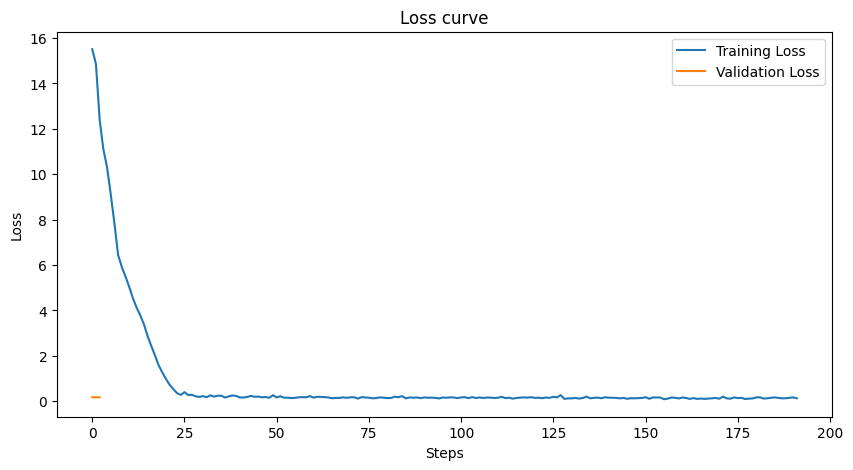

In [12]:
import matplotlib.pyplot as plt

# loss values from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = range(len(train_loss))

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

# Generate predictions

In [14]:
import difflib
from IPython.display import display, HTML

def highlight_diff(sentence1, sentence2):
    diff = difflib.ndiff(sentence1, sentence2)
    highlighted = []
    
    for char in diff:
        if char.startswith('-'):
            highlighted.append(f"<span style='color:red'>{char[2:]}</span>")
        elif char.startswith('+'):
            highlighted.append(f"<span style='color:green'>{char[2:]}</span>")
        else:
            highlighted.append(char[2:])
    
    return ''.join(highlighted)

In [13]:
from datasets import load_from_disk
import pandas as pd

# load-in a cleaned dataset
swipe_dataset = load_from_disk("../data/swipe_clean")

In [15]:
example = swipe_dataset['test_id'][1]  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = tokenizer(example['r_content'], return_tensors="pt", truncation=True, padding="max_length", max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

output_ids = model.generate(
    **inputs, 
    #max_new_tokens = 50,
    max_length=512, 
    min_length=50, 
    length_penalty=1.0, 
    num_beams=4, 
    #no_repeat_ngram_size=2,
    early_stopping=True
)
simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Original: {example['r_content']}", end='\n\n')
print(f"Simplified: ")
print(simplified_text, end='\n\n')
print(f"Simplified (highlighted): ")
display(HTML(highlight_diff(example['r_content'],simplified_text)))

/home/6/ud03926/nlp/lib64/python3.9/site-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Original: Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the former Soviet Union, and was also widely taught in schools in member countries of the Warsaw Pact. In Soviet times, Russian was often strongly promoted to the detriment of other local languages. While many of the countries of the former Soviet Union are now promoting their local languages rather than Russian, Russian remains widely spoken in these areas and is often used for intercommunication between these countries. Russian is one of the official languages of the United Nations. Russian is written using the Cyrillic alphabet. Russenorsk is a pidgin language combining Russian and Norwegian. See also: Common phrases in different languages See also: Languages of China --

Simplified: 
Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the for

# Evaluation

In [16]:
from tqdm import tqdm

predictions = []
references = []  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for example in tqdm(swipe_dataset['test_id']):
    # tokenize the text
    input_ids = tokenizer(example['r_content'], return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    # move input_ids to the same device as the model
    input_ids = {key: value.to(device) for key, value in input_ids.items()}
    
    # generate prediction
    output_ids = model.generate(**input_ids,max_length = 512, min_length=50, length_penalty=1.0, num_beams=4, early_stopping=True) #max_length=200, min_length=50,
    simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    predictions.append(simplified_text)
    references.append(example['s_content'])

100%|███████████████████████████████████████████| 483/483 [09:54<00:00,  1.23s/it]


In [17]:
df_results = pd.DataFrame({
    'text': swipe_dataset['test_id']['r_content'],
    'reference': swipe_dataset['test_id']['s_content'],
    'prediction': predictions
})

df_results.to_csv("../data/predictions_bart-large-swipe-adamw.csv", index=False)
df_results.head()

,text,reference,prediction
0,The term jargon may have the following meaning...,Jargon is a special way to use words that are ...,The term jargon may have the following meaning...
1,"Russian (Russkij yazyk, Русский язык) is the m...",Russian (русский язык (russkij yazyk)) is the ...,"Russian (Russkij yazyk, Русский язык) is the m..."
2,"Great Britain, also called Britain, is an isla...",Great Britain is the main part of the United K...,"Great Britain, also called Britain, is an isla..."
3,"Transport, or transportation (as it is called ...",Transport is the movement of people and things...,"Transport, or transportation (as it is called ..."
4,Stockholm (help·info) (IPA: ['stɔkhɔlm]; UN/LO...,Stockholm is the capital of Sweden. It is loca...,Stockholm (help·info) (IPA: ['stɔkhɔlm]; UN/LO...


# SARI score

In [18]:
from datasets import load_metric
import pandas as pd

sari_metric = load_metric("sari")
sari_scores = []

for index, row in tqdm(df_results.iterrows(), total=len(df_results)):
    r_content = row['text'] 
    s_content = row['reference']  
    prediction = row['prediction']  
    
    sari_score = sari_metric.compute(
        sources=[r_content],
        predictions=[prediction],
        references=[[s_content]] 
    )
    
    sari_scores.append(sari_score['sari'])

/tmp/1042984.1.all.q/ipykernel_562261/1243258573.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  sari_metric = load_metric("sari")
100%|██████████████████████████████████████████| 483/483 [00:03<00:00, 136.54it/s]


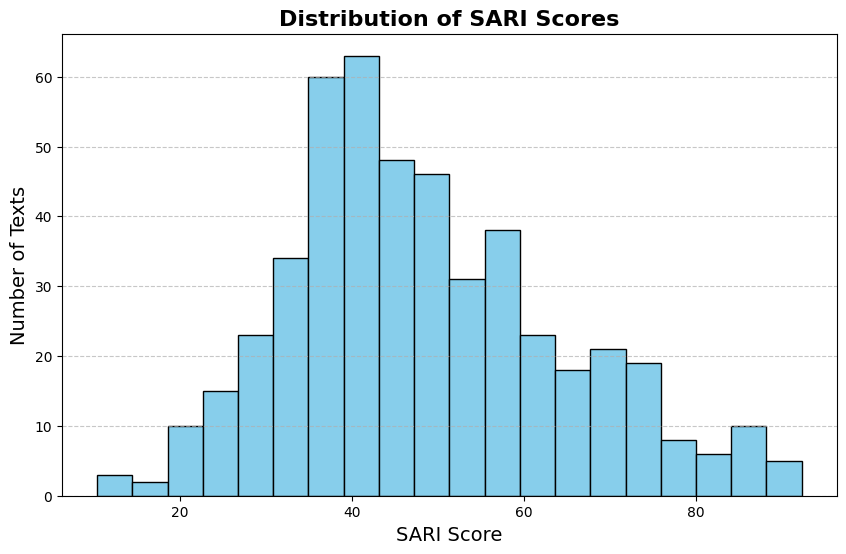

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sari_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SARI Scores', fontsize=16, fontweight='bold')
plt.xlabel('SARI Score', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
import numpy as np

print("Overall SARI score: ", np.mean(sari_scores))

Overall SARI score:  48.50384310428547
